In [1]:
# %% Importing the libraries

# python
import math
import time
import random
import os
import sys
import copy

# numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter

# panda
import pandas as pd

# Symbol python
import sympy as sym

# PyTroch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision
import torchvision.transforms as T
from torchsummary import summary

# Seaborn
import seaborn as sns

# sckitlearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
import sklearn.metrics as skm

# scipy
import scipy.stats as stats
from scipy.signal import convolve2d

# read image
from imageio import imread

# set directory
import inspect, os.path
filename = inspect.getframeinfo(inspect.currentframe()).filename
path_dir = os.path.dirname(os.path.abspath(filename))
os.chdir(path_dir) # set the working directory
cd = os.getcwd()

# SSL
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

# Settings
np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.5  # default 0.8
plt.rcParams["figure.subplot.hspace"] = 0.25

In [2]:
#%% Import Class & Functions

# from google.colab import drive
# drive.mount('/content/drive')

# sys.path.append('/content/drive/MyDrive/ColabNotebooks')

# # CNN Class
# import Class.CNN as CNN

# # Function
# from Function.dSplit import dSplit
# import Function.LossFunc as LF

In [3]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

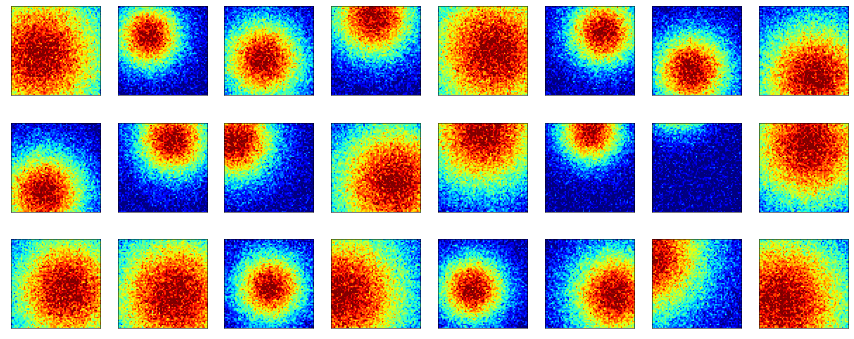

In [4]:
#%% Generate Gauss data

ndataClass = 1000
imgSize = 64

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)


# initialize tensors
imgDat = torch.zeros(2*ndataClass, 1, imgSize, imgSize)

# generate Guass data
for i in range(len(imgDat)):
    
    # center width
    cw = np.random.rand()*3 + 2
    
    # pick random centers
    C = 2*np.random.randn(2)
    
    # Guass equation
    G  = np.exp( -( (X-C[0])**2 + (Y-C[1])**2) / (2*cw**2) )
    
    # add random noise
    G  = G + np.random.randn(imgSize, imgSize)/10

    # store in tensors
    imgDat[i, 0, :, :] = torch.tensor(G)

# visualize some images
fig, axs = plt.subplots(3, 8, figsize=(15, 6))

for i, ax in enumerate(axs.flatten()):
    
    pic2show = np.random.randint(len(imgDat))
    G = np.squeeze( imgDat[pic2show, 0, :, :] )
    ax.imshow(G, vmin=0, vmax=1, cmap='jet')
    # ax.set_title(f'{tuple(np.round(labels[pic2show, :].detach().numpy(), 2))}')
    ax.set_xticks([])
    ax.set_yticks([])
    

In [5]:
#%% data preprocessing

# **********normalize the data to [-1 1]************
dataNorm = imgDat / torch.max(imgDat) # to [0 1]
# dataNorm = imgDat.clone()
# dataNorm = 2*dataNorm - 1 # to [-1 1]
# reshape to 2D
# dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)
dataNorm.shape

torch.Size([2000, 1, 64, 64])

(array([3.0000e+00, 1.0000e+01, 6.2000e+01, 2.9200e+02, 8.5000e+02,
        2.7200e+03, 6.7960e+03, 1.5398e+04, 3.1400e+04, 5.5194e+04,
        8.7337e+04, 1.2531e+05, 1.6227e+05, 1.9474e+05, 2.1840e+05,
        2.3585e+05, 2.4626e+05, 2.5484e+05, 2.6265e+05, 2.6958e+05,
        2.7764e+05, 2.8622e+05, 2.9458e+05, 3.0292e+05, 3.1166e+05,
        3.1822e+05, 3.2716e+05, 3.3377e+05, 3.3911e+05, 3.4431e+05,
        3.4791e+05, 3.4950e+05, 3.4824e+05, 3.4179e+05, 3.2720e+05,
        3.0092e+05, 2.6220e+05, 2.1271e+05, 1.5796e+05, 1.0788e+05,
        6.5937e+04, 3.5744e+04, 1.7109e+04, 7.4100e+03, 2.6910e+03,
        9.0100e+02, 2.6200e+02, 6.6000e+01, 1.6000e+01, 7.0000e+00]),
 array([-0.3115, -0.2853, -0.2591, -0.2328, -0.2066, -0.1804, -0.1541,
        -0.1279, -0.1017, -0.0755, -0.0492, -0.023 ,  0.0032,  0.0295,
         0.0557,  0.0819,  0.1082,  0.1344,  0.1606,  0.1869,  0.2131,
         0.2393,  0.2655,  0.2918,  0.318 ,  0.3442,  0.3705,  0.3967,
         0.4229,  0.4492,  0.4754,

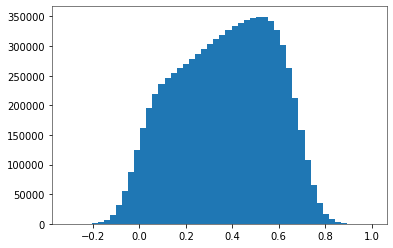

In [6]:
# check value in the img

# plot hist
x = dataNorm[:].view(-1, 1).detach().numpy()
plt.hist(x, 50)

Models Classes

In [7]:
class discriminatorNet(nn.Module):

  def __init__(self):
    super().__init__()
    
    # print
    self.print = False

    # convolution layers
    self.conv1 = nn.Conv2d(  1,  64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64, 128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,   1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)
    
  def forward(self, x):

    print('\n####### discriminatorNet #######') if self.print else None

    x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
    print(x.shape) if self.print else None

    x = F.leaky_relu(self.conv2(x), 0.2)
    print(x.shape) if self.print else None
    x = self.bn2(x)

    x = F.leaky_relu(self.conv3(x), 0.2)
    print(x.shape) if self.print else None
    x = self.bn3(x)

    x = F.leaky_relu(self.conv4(x), 0.2)
    print(x.shape) if self.print else None
    x = self.bn4(x)

    x = torch.sigmoid(self.conv5(x))
    print(x.shape) if self.print else None
    x = x.view(-1, 1)

    # one-time print
    self.print = False

    return x

In [8]:
class generatorNet(nn.Module):

  def __init__(self):
    super().__init__()
    
    # print
    self.print = False

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128,  64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,    1, 4, 2, 1, bias=False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self, x):

    print('\n####### generatorNet #######') if self.print else None

    x = F.relu( self.bn1(self.conv1(x)) )
    print(x.shape) if self.print else None

    x = F.relu( self.bn2(self.conv2(x)) )
    print(x.shape) if self.print else None

    x = F.relu( self.bn3(self.conv3(x)) )
    print(x.shape) if self.print else None

    x = F.relu( self.bn4(self.conv4(x)) )
    print(x.shape) if self.print else None

    x = torch.tanh( self.conv5(x) )
    print(x.shape) if self.print else None

    # one-time print
    self.print = False

    return x

Models Instance & params

In [23]:
# models instance
d_net = discriminatorNet().to(device)
d_net.print = True
g_net = generatorNet().to(device)
g_net.print = True

# loss function
loss_fun = nn.BCELoss()

# optimizer
d_optimizer = torch.optim.Adam(d_net.parameters(), lr=0.0002, betas=(0.5, 0.999)) # coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
g_optimizer = torch.optim.Adam(g_net.parameters(), lr=0.0002, betas=(0.5, 0.999))

# training epochs
epochs = 1500

# batch size
batch_size = 100

In [24]:
# init vars to store results
d_loss = torch.zeros((epochs)) # for discriminator
g_loss = torch.zeros((epochs)) # for generator
d_pred_train_d = torch.zeros((epochs)) # discriminator prediction on training discriminator
d_pred_train_g = torch.zeros((epochs)) # discriminator prediction on training generator

Train model

In [25]:
for epochi in range(epochs):

  # mini-batch for real and fake images for every epoch

  # REAL images
  randidx = torch.randint(dataNorm.shape[0], (batch_size, )) 
  real_img = dataNorm[randidx, :].to(device) # torch.Size([100, 1, 64, 64])

  # labels for REAL and FAKE images
  real_labels = torch.ones(batch_size, 1).to(device) # all labels are 1
  fake_labels = torch.zeros(batch_size, 1).to(device) # all labels are 0


  # ----** Train discriminator **----

  # forward pass, loss: **REAL** pictures
  pred_real   = d_net(real_img) # REAL images into discriminator
  d_loss_real = loss_fun(pred_real, real_labels) 
  
  # forward pass, loss: **FAKE** pictures
  # FAKE images
  fake_img = torch.randn(batch_size, 100, 1, 1).to(device)
  g_fake_img = g_net(fake_img) # output from generator 
  pred_fake   = d_net(g_fake_img) # FAKE images into discriminator
  d_loss_fake = loss_fun(pred_fake, fake_labels) 
  
  # loss
  d_comb_loss = d_loss_real + d_loss_fake # combine loss
  d_loss[epochi]  = d_comb_loss.item()
  d_pred_train_d[epochi] = torch.sum( (pred_real>0.5).float() ).detach() / len(pred_real)

  # backprop
  d_optimizer.zero_grad()
  d_comb_loss.backward()
  d_optimizer.step()


  # ----** Train generator **----

  # forward pass, loss: **FAKE** pictures with **REAL** labels
  fake_img = torch.randn(batch_size, 100, 1, 1).to(device)
  g_fake_img = g_net(fake_img) # # output from generator
  pred_fake = d_net(g_fake_img)

  # loss
  g_pred_loss = loss_fun(pred_fake, real_labels)
  g_loss[epochi]  = g_pred_loss.item()
  d_pred_train_g[epochi] = torch.sum( (pred_fake>0.5).float() ).detach() / len(pred_fake)
  
  # backprop
  g_optimizer.zero_grad()
  g_pred_loss.backward()
  g_optimizer.step()

  # print out a status message
  if (epochi+1)%100==0:
    msg = f'Finished epoch {epochi+1}/{epochs}'
    sys.stdout.write('\r' + msg)



####### discriminatorNet #######
torch.Size([100, 64, 32, 32])
torch.Size([100, 128, 16, 16])
torch.Size([100, 256, 8, 8])
torch.Size([100, 512, 4, 4])
torch.Size([100, 1, 1, 1])

####### generatorNet #######
torch.Size([100, 512, 4, 4])
torch.Size([100, 256, 8, 8])
torch.Size([100, 128, 16, 16])
torch.Size([100, 64, 32, 32])
torch.Size([100, 1, 64, 64])
Finished epoch 1500/1500

Result

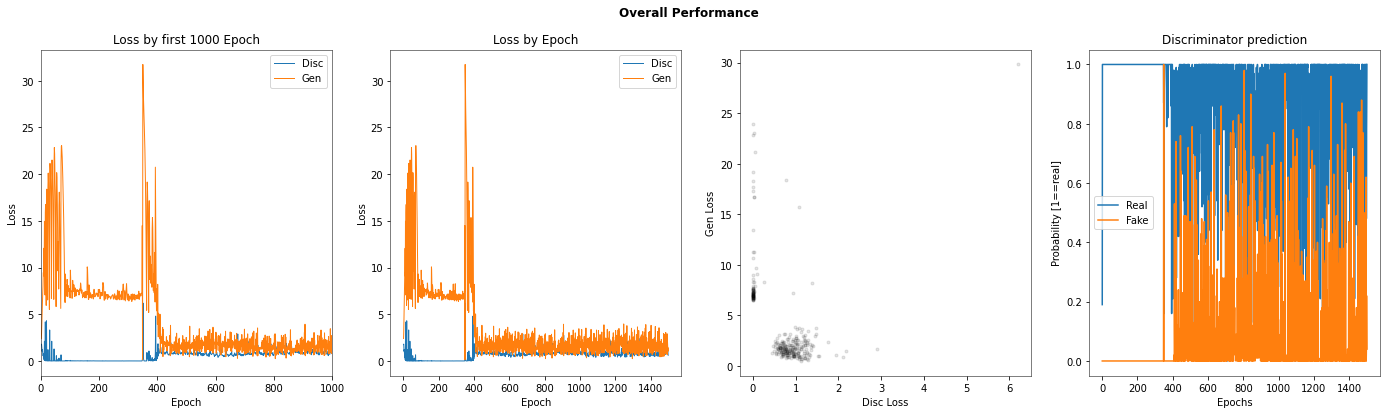

In [26]:
#%% plot model performance


# plot
fig = plt.figure(figsize=(24, 6))
fig.tight_layout()
fig.suptitle(f'Overall Performance', fontweight='bold')

# setting
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=None, hspace=0.25)


# plot losses
plt.subplot(1, 4, 1)
y_plot_1 = np.array(d_loss).T
y_plot_2 = np.array(g_loss).T
plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
plt.plot(np.arange(1, epochs+1), y_plot_2, linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss by first 1000 Epoch')
plt.legend(['Disc', 'Gen'])
plt.xlim([0, 1000])


# plot losses
plt.subplot(1, 4, 2)
y_plot_1 = np.array(d_loss).T
y_plot_2 = np.array(g_loss).T
plt.plot(np.arange(1, epochs+1), y_plot_1, linewidth=1)
plt.plot(np.arange(1, epochs+1), y_plot_2, linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss by Epoch')
plt.legend(['Disc', 'Gen'])


# plot losses
plt.subplot(1, 4, 3)
y_plot_1 = np.array(d_loss).T
y_plot_2 = np.array(g_loss).T
plt.plot(y_plot_1[::5], y_plot_2[::5], 'k.', alpha=0.1)
plt.xlabel('Disc Loss')
plt.ylabel('Gen Loss')


# plot discriminator output
plt.subplot(1, 4, 4)
y_plot_1 = np.array(d_pred_train_d).T
y_plot_2 = np.array(d_pred_train_g).T
plt.plot(np.arange(1, epochs+1), y_plot_1)
plt.plot(np.arange(1, epochs+1), y_plot_2)
plt.title('Discriminator prediction')
plt.xlabel('Epochs')
plt.ylabel('Probability [1==real]')
plt.legend(['Real', 'Fake'])

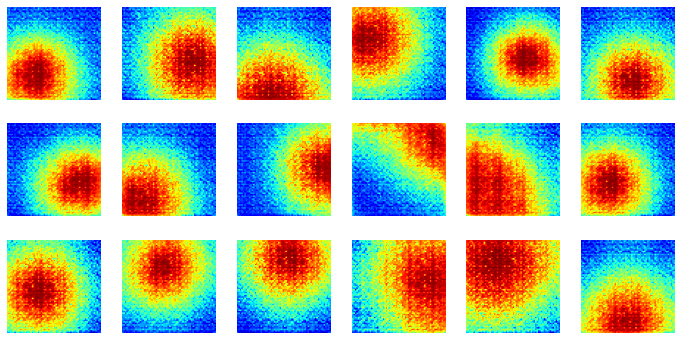

In [27]:
# generate the images from the generator network

# switch to eval mode
g_net.eval()

# create fake data
fake_data = g_net(torch.randn(batch_size, 100, 1, 1).to(device)).cpu()

# plot
fig, axs = plt.subplots(3, 6, figsize=(12, 6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i].squeeze().detach(), cmap='jet')
  ax.axis('off')